<a href="https://colab.research.google.com/github/msenDaGOAT/Gravitational-Wave-Isolation-with-Autoencoder-Neural-Network-Cascade/blob/main/GW_CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dependencies

In [ ]:
!pip install tensorflow_io
!pip install pycbc
!pip install gwpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ..

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

# Need to upload bg_list.txt to Google Drive before running this code
# This stores all the background noise samples sourced from GwPy so
# you don't need to spend 20 minutes re-importing them.
with open('/content/drive/MyDrive/bg_list.txt', 'rb') as file:
      
    # Call load method to deserialze
    bg_list = pickle.load(file)
  
    print(bg_list)

[[<TimeSeries([-1.05626410e-19, -1.03826174e-19, -8.82518953e-20,
             ...,  3.84765768e-20,  5.37457456e-20,
              6.58205641e-20]
            unit=Unit(dimensionless),
            t0=<Quantity 1.24244324e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>, <TimeSeries([-4.37786503e-19, -4.29850910e-19, -4.22400664e-19,
             ..., -2.81155761e-19, -2.81414521e-19,
             -2.79750683e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.24244324e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>, <TimeSeries([ 1.23432933e-20,  1.49151569e-20,  2.65910876e-20,
             ..., -1.89580959e-20, -2.78727954e-20,
             -3.50709785e-20]
            unit=Unit(dimensionless),
            t0=<Quantity 1.24244324e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>], [<TimeSeries([4.01227912e-19

In [ ]:
from pycbc.detector import Detector, get_available_detectors
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tqdm import tqdm
import os
import librosa

In [ ]:
#Very important function
from scipy.signal import spectrogram as get_spec

def spectros(audio):
  wave = audio/tf.math.reduce_max(audio)
  audio_y = tf.squeeze(wave, axis=-1)
  spectrogram = tfio.audio.spectrogram(audio_y, nfft=512, window=512, stride=256)

  img = tf.image.rot90(tf.expand_dims(spectrogram, axis=-1), k=1)
  spectrogram = tf.squeeze(img, axis=-1)
  spectrogram = spectrogram/tf.math.reduce_max(spectrogram) #NORMALIZE!!!!
  spectrogram = tf.clip_by_value(spectrogram, 0, 1)
  y = tf.where(tf.math.is_nan(spectrogram), tf.zeros_like(spectrogram), spectrogram)

  return y

def crop_upper(img, length):
  img = tf.image.crop_to_bounding_box(tf.expand_dims(img, axis=-1), 257-96, 0, 96, length) #Crops to bottom 129 pixels
  spectrogram = tf.squeeze(img, axis=-1)
  spectrogram = spectrogram/tf.math.reduce_max(spectrogram)
  spectrogram = tf.clip_by_value(spectrogram, 0, 1)
  final = tf.where(tf.math.is_nan(spectrogram), tf.zeros_like(spectrogram), spectrogram)

  return final

def window(img, offset):
  img = tf.image.crop_to_bounding_box(tf.expand_dims(img, axis=-1), 0, offset, 96, 96)
  return tf.squeeze(img, axis=-1)

def normalize(wav):
  max = tf.math.reduce_max(wav, axis=0)
  wav /= max
  return wav, max

#Initialize and Test the Datagen for the Autoencoders

In [ ]:
#Datagen

files = os.listdir("/content/drive/MyDrive/GW_Data/x")

inputs = []
targets = []

for filename in tqdm(files):
  exact_path = "/content/drive/MyDrive/GW_Data/x/"+str(filename)
  #Input
  if exact_path.__contains__('.wav'):
    try:
      wav_x = tf.io.read_file(exact_path)
      audio, sr = tf.audio.decode_wav(wav_x)
      audio_x = tf.squeeze(audio, axis=-1)
      inputs.append(audio_x)
      targets.append(audio_x)
    except:
      print("Issue with "+str(exact_path))

100%|██████████| 400/400 [00:04<00:00, 80.45it/s] 


In [ ]:
#ETC. Map Functions
def decoder_map(x,y):
  x, y = x_y(x,y)
  return tf.expand_dims(y, axis=-1), tf.expand_dims(y, axis=-1)

def x_offset(x,y):
  offset = np.random.randint(96*2)

  #Input
  a = np.random.randint(20)
  b = np.random.randint(2)
  bg = tf.constant((bg_list[a][b]).value, dtype='float32')
  bg, _ = normalize(bg[-18*4096:])

  silencer = 0.00025*np.random.randint(4,7) #MUY importante 0.0005 to 0.005
  x = tf.math.add(bg, silencer*y) #norm(A) + s*norm(c)

  x_spect = spectros(tf.expand_dims(x, axis=-1)) #norm(norm(A) + s*norm(c))
  x_spect = crop_upper(x_spect, 288)
  x_spect = window(x_spect, offset)
  x_spect = tf.math.log(x_spect)

  return imgNorm(x_spect), tf.constant([offset/192], dtype='float32')

def focus(x):
  if x.shape == (96,96):
    x = x[35:90,-20:]
  elif x.shape == (1,96,96):
    x = x[:,35:90,-20:]
  elif x.shape == (1,96,96,1):
    x = x[:,35:90,-20:,:]
  return x

def focused_map(x,y):
  x,y = x_y(x,y)
  return focus(x), y

In [ ]:
#Map Functions

from scipy.signal import butter, filtfilt, iirnotch
from scipy import stats

def bp(signal, low=60, high=250):
  fs = 4096
  nyq = fs/2
  low /= nyq
  high /= nyq
  order = 2

  b,a = butter(order, [low, high], 'bandpass', analog=False)
  y = filtfilt(b,a, signal, axis=0)
  return y

def notch(signal, delete=350):
  fs = 4096
  Q = 30
  
  b,a = iirnotch(delete, Q, fs)
  y = filtfilt(b,a, signal, axis=0)
  return y

def clip(img, p): #Images only
  bottom50 = np.percentile(img, p)
  img = tf.clip_by_value(img, bottom50, 100)
  return img

def imgNorm(img):
  max = tf.math.reduce_max(img)
  min = tf.math.reduce_min(img)
  avg = (max+min)/2.0
  final = tf.math.add(img, -avg*tf.ones_like(img))
  final = final/(max-min)
  final = tf.math.add(final, 0.5*tf.ones_like(final))
  return final

def to_3d(x):
  final = tf.concat([x, x, x], axis=-1)
  return final

def piece_together(x):
  x = tf.cast(x, 'float32')
  top = tf.zeros((35,96), dtype='float32')
  side = tf.zeros((90-35, 96-20), dtype='float32')
  bottom = tf.zeros((96-90, 96), dtype='float32')
  final = tf.concat([side, x], axis=-1)
  final = tf.concat([top, final, bottom], axis=0)
  return final


#Actual Map Functions
def x_y(x, y):
  #offset = np.random.randint(96, 96*2-16)
  offset = 100

  #Input
  a = np.random.randint(20) 
  b = np.random.randint(2)
  bg = tf.constant((bg_list[a][b]).value, dtype='float32')
  bg, _ = normalize(bg[-18*4096:])

  #silencer = tf.random.uniform(shape=[1], minval=0.0003, maxval=0.0009) #MUY importante 0.0004 to 0.0010
  silencer = 0.000175
  x = tf.math.add(bg, silencer*y) #norm(A) + s*norm(c)
  audio0 = tf.py_function(func=bp, inp=[x], Tout=tf.float32)
  audio = tf.py_function(func=bp, inp=[audio0], Tout=tf.float32)

  x_spect = spectros(tf.expand_dims(audio, axis=-1)) #norm(norm(A) + s*norm(c))
  x_spect = crop_upper(x_spect, 288)
  x_spect = window(x_spect, offset)
  x_spect = focus(x_spect)
  x_spect = piece_together(x_spect)
  x_spect = tf.py_function(func=clip, inp=[x_spect, 97.5], Tout=tf.float32)
  # x_spect = tf.math.log(x_spect)

  #Target
  y_spect = spectros(tf.expand_dims(y, axis=-1))
  y_spect = crop_upper(y_spect, 288)
  y_spect= window(y_spect, offset) #norm(c)

  return tf.expand_dims(imgNorm(x_spect), axis=-1), tf.expand_dims(y_spect, axis=-1)

def x_yForTest(x, y, silencer):
  #offset = np.random.randint(96, 96*2-16)
  offset = 100

  #Input
  a = np.random.randint(20) 
  b = np.random.randint(2)
  bg = tf.constant((bg_list[a][b]).value, dtype='float32')
  bg, _ = normalize(bg[-18*4096:])

  #silencer = tf.random.uniform(shape=[1], minval=0.0003, maxval=0.0009) #MUY importante 0.0006 to 0.0012
  x = tf.math.add(bg, silencer*y) #norm(A) + s*norm(c)
  audio0 = tf.py_function(func=bp, inp=[x], Tout=tf.float32)
  audio = tf.py_function(func=bp, inp=[audio0], Tout=tf.float32)

  x_spect = spectros(tf.expand_dims(audio, axis=-1)) #norm(norm(A) + s*norm(c))
  x_spect = crop_upper(x_spect, 288)
  x_spect = window(x_spect, offset)
  x_spect = focus(x_spect)
  x_spect = piece_together(x_spect)
  x_spect = tf.py_function(func=clip, inp=[x_spect, 92], Tout=tf.float32)

  #Target
  y_spect = spectros(tf.expand_dims(y, axis=-1))
  y_spect = crop_upper(y_spect, 288)
  y_spect= window(y_spect, offset) #norm(c)

  return tf.expand_dims(imgNorm(x_spect), axis=-1), y_spect, y, x

In [ ]:
gw170817 = [inputs[3],inputs[27],inputs[5],inputs[21],inputs[9]]

train_ds_light = tf.data.Dataset.from_tensor_slices((inputs[6:21]+inputs[22:27]+inputs[28:35], targets[6:21]+targets[22:27]+targets[28:35]))
train_ds_light = train_ds_light.map(x_y).batch(1).prefetch(25).shuffle(20)

val_ds_light = tf.data.Dataset.from_tensor_slices((inputs[:4]+inputs[35:40], targets[:4]+targets[35:40]))
val_ds_light = val_ds_light.map(x_y).batch(1).prefetch(25).shuffle(20)

train_ds_heavy = tf.data.Dataset.from_tensor_slices((inputs[40:280], targets[40:280]))
train_ds_heavy = train_ds_heavy.map(x_y).batch(1).prefetch(25).shuffle(20)

val_ds_heavy = tf.data.Dataset.from_tensor_slices((inputs[280:400], targets[280:400]))
val_ds_heavy = val_ds_heavy.map(x_y).batch(1).prefetch(25).shuffle(20)

train_ds_xs = tf.data.Dataset.from_tensor_slices((gw170817, gw170817))
train_ds_xs = train_ds_xs.map(x_y).batch(1).prefetch(25).shuffle(10)

train_ds_full = tf.data.Dataset.from_tensor_slices((inputs[10:85]+gw170817+gw170817+gw170817, targets[10:85]+gw170817+gw170817+gw170817))
train_ds_full = train_ds_full.map(x_y).batch(1).prefetch(25).shuffle(20)

val_ds_full = tf.data.Dataset.from_tensor_slices((inputs[:10]+inputs[300:], targets[:10]+targets[300:]))
val_ds_full = val_ds_full.map(x_y).batch(1).prefetch(25).shuffle(20)

decoder_trainer = tf.data.Dataset.from_tensor_slices((inputs[10:85]+gw170817+gw170817+gw170817, targets[10:85]+gw170817+gw170817+gw170817))
decoder_trainer = decoder_trainer.map(decoder_map).batch(1).prefetch(25).cache().shuffle(250)

decoder_trainer_val = tf.data.Dataset.from_tensor_slices((inputs[:10]+inputs[300:], targets[:10]+targets[300:]))
decoder_trainer_val = decoder_trainer_val.map(decoder_map).batch(1).prefetch(25).cache().shuffle(250)

decoder_test = tf.data.Dataset.from_tensor_slices((inputs, targets))
decoder_test = decoder_test.map(decoder_map).batch(1).prefetch(25).cache().shuffle(100)

In [ ]:
#@title Preprocessing Tester { run: "auto" }
idx = 216 #@param {type:"slider", min:0, max:399, step:1}
test_x, test_y, raw = x_y(inputs[idx], targets[idx])
plt.imshow(test_x)
plt.axis('off')
plt.show()
plt.imshow(test_y)
plt.axis('off')
plt.show()

raw = spectros(tf.expand_dims(raw, axis=-1))
raw = crop_upper(raw, 288)
raw = window(raw, 100)
plt.axis('on')
plt.imshow(tf.math.log(raw))

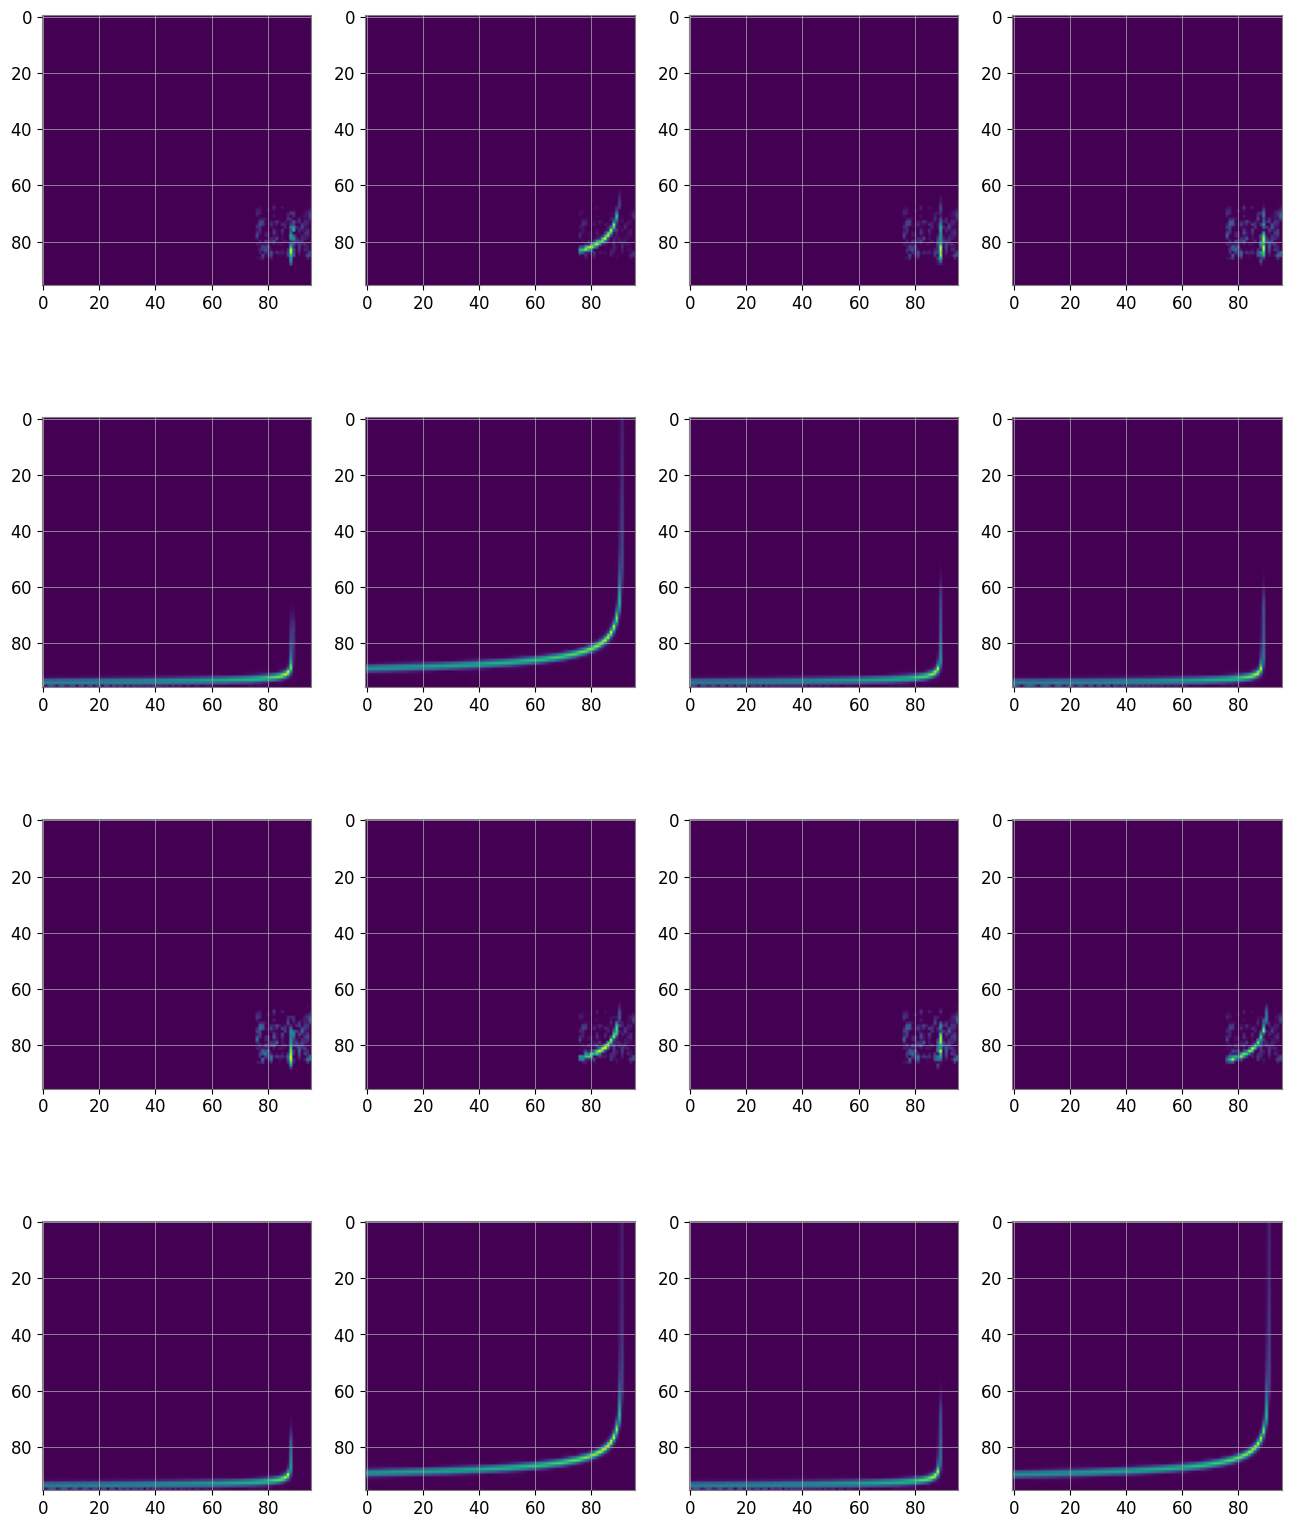

In [ ]:
x = []
y = []
for image, label in val_ds.take(8):
  x.append(image)
  y.append(label)

fig, axs = plt.subplots(4,4, figsize=(16,20))

for i in range(2):
  for a in range(4):
    axs[2*i,a].imshow((tf.squeeze(x[4*i+a], axis=0)[:,:,0]).numpy())
    axs[2*i+1,a].imshow(y[4*i+a][0])
    # axs[2*i,a].axis('off')
    # axs[2*i+1,a].axis('off')
plt.show()

#Create and Train AE Cascade

##Primary AE

In [ ]:
#Primary Autoencoder (Residual AE)
import tensorflow.keras.layers as lay

input = tf.keras.Input(shape=(96,96,1))
add_back = lay.SeparableConv2D(32, (3,3), padding="same", name="branch_off_conv")(input)
add_back = lay.BatchNormalization(name="branch_off_batch_norm")(add_back)
add_back = lay.Activation("sigmoid" ,name="branch_off_sigmoid")(add_back)

#Encoder
x = lay.SeparableConv2D(32, (3,3), padding="same")(input)
x = lay.BatchNormalization()(x)
x = lay.LeakyReLU(alpha=0.2)(x)
x = lay.MaxPool2D(2)(x)

x = lay.SeparableConv2D(64, (3,3), padding="same")(x)
x = lay.BatchNormalization()(x)
x = lay.LeakyReLU(alpha=0.2)(x)
x = lay.MaxPool2D(2)(x)

x = lay.Flatten()(x)
x = lay.Dense(128, activation='sigmoid')(x)
x = lay.Dense(24*24*64, activation='sigmoid')(x)
x = lay.Reshape((24, 24, 64))(x)

#Decoder
x = lay.Conv2DTranspose(32, (4,4), strides=2, padding="same")(x)
x = lay.BatchNormalization()(x)
x = lay.LeakyReLU(alpha=0.2)(x)
x = lay.Conv2DTranspose(32, (4,4), strides=2, padding="same")(x)
x = lay.BatchNormalization()(x)
x = lay.LeakyReLU(alpha=0.2)(x)

x = lay.Add()([x, add_back])

x = lay.Conv2DTranspose(1, (4,4), strides=1, padding="same")(x)
x = lay.BatchNormalization()(x)


output = lay.Activation("sigmoid")(x)

autoencoder = tf.keras.Model(inputs=input, outputs=output)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (None, 96, 96, 32)  73          ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 32)  128         ['separable_conv2d[0][0]']       
 alization)                                                                                       
                                                                                              

In [ ]:
#Two Copies
io = tf.keras.Input(shape=(96,96,1))
very_lightAE = tf.keras.models.clone_model(autoencoder)
very_lightAE._name="Very_Light_AE"
very_lightAE.summary()
lightAE = tf.keras.models.clone_model(autoencoder)
lightAE._name="Light_AE"
lightAE.summary()
heavyAE = tf.keras.models.clone_model(autoencoder)
heavyAE._name="Heavy_AE"
heavyAE.summary()

Model: "Very_Light_AE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (None, 96, 96, 32)  73          ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 32)  128         ['separable_conv2d[0][0]']       
 alization)                                                                                       
                                                                                      

In [ ]:
from tensorflow.keras.optimizers import Adam
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

lightAE.compile(optimizer=Adam(learning_rate=0.00005), loss=SSIMLoss) #binary_crossentropy because of sigmoid output, default lr=0.001
lightAE.fit(train_ds_light, validation_data=val_ds_light, epochs=300)

In [ ]:
heavyAE.compile(optimizer=Adam(learning_rate=0.001), loss=SSIMLoss) #binary_crossentropy because of sigmoid output, default lr=0.001
heavyAE.fit(train_ds_heavy, validation_data=val_ds_heavy, epochs=300)

In [ ]:
very_lightAE.compile(optimizer=Adam(learning_rate=0.001), loss=SSIMLoss) #binary_crossentropy because of sigmoid output, default lr=0.001
very_lightAE.fit(train_ds_xs, epochs=300)

Epoch 1/300
5/5 [==============================] - 10s 245ms/step - loss: 0.0373
Epoch 2/300
5/5 [==============================] - 2s 363ms/step - loss: 0.0384
Epoch 3/300
5/5 [==============================] - 2s 363ms/step - loss: 0.0371
Epoch 4/300
5/5 [==============================] - 2s 235ms/step - loss: 0.0357
Epoch 5/300
5/5 [==============================] - 1s 237ms/step - loss: 0.0367
Epoch 6/300
5/5 [==============================] - 2s 236ms/step - loss: 0.0350
Epoch 7/300
5/5 [==============================] - 1s 235ms/step - loss: 0.0374
Epoch 8/300
5/5 [==============================] - 2s 258ms/step - loss: 0.0348
Epoch 9/300
5/5 [==============================] - 2s 359ms/step - loss: 0.0347
Epoch 10/300
5/5 [==============================] - 2s 237ms/step - loss: 0.0348
Epoch 11/300
5/5 [==============================] - 1s 234ms/step - loss: 0.0389
Epoch 12/300
5/5 [==============================] - 1s 212ms/step - loss: 0.0377
Epoch 13/300
5/5 [==================

KeyboardInterrupt: ignored

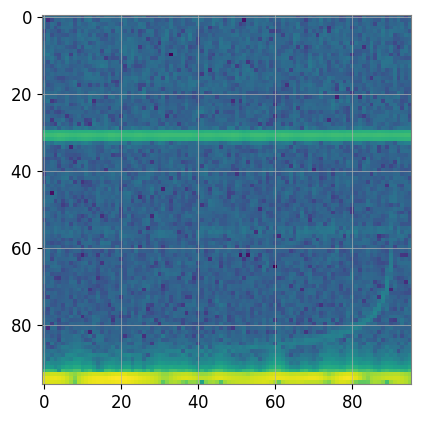

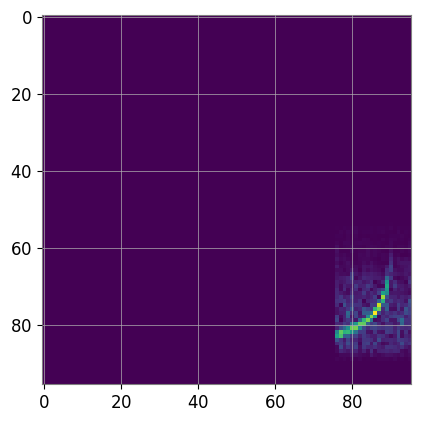

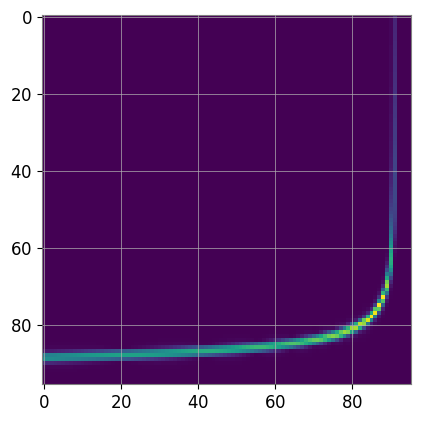

(96, 96, 1)
1/1 [==============================] - 0s 62ms/step


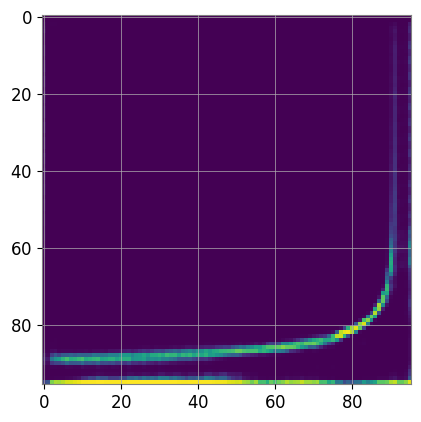

tf.Tensor(0.15148842, shape=(), dtype=float32)


In [ ]:
#@title Visualize Performance on Test Data { run: "auto" }
num = 21 #@param {type:"slider", min:0, max:399, step:1}
exact_path = "/content/drive/MyDrive/GW_Data/x/"+str(files[num])
wav_x = tf.io.read_file(exact_path)
audio, sr = tf.audio.decode_wav(wav_x)
audio = tf.squeeze(audio, axis=-1)
x_test, y_test, gt, dirty = x_yForTest(audio, audio)

dirty_spect = spectros(tf.expand_dims(dirty, axis=-1))
dirty_spect = crop_upper(dirty_spect, 288)
dirty_spect = window(dirty_spect, 100)

plt.imshow(tf.math.log(dirty_spect))
plt.show()
plt.imshow(x_test[:,:,0])
plt.show()
plt.imshow(y_test)
plt.show()


print(x_test.shape)
cleaned_result1 = very_lightAE.predict(tf.expand_dims(x_test, axis=0))
plot_this = tf.squeeze(tf.squeeze(cleaned_result1, axis=0), axis=-1)
plt.imshow(plot_this)
plt.show()

print(SSIMLoss(tf.expand_dims(x_test, axis=0), cleaned_result1))

In [ ]:
very_lightAE.save("drive/MyDrive/hwg_initial_veryLight/model")

##Secondary AE

###Decoder
Training the second half of this CAE separaetely improves its performance

In [ ]:
very_lightAE = tf.keras.models.load_model("drive/MyDrive/hwg_initial_veryLight/model", compile=False)
lightAE = tf.keras.models.load_model("drive/MyDrive/hwg_initial_light/model", compile=False)
heavyAE = tf.keras.models.load_model("drive/MyDrive/hwg_initial_heavy/model", compile=False)

In [ ]:
for layer in heavyAE.layers:
  layer.trainable = False
for layer in lightAE.layers:
  layer.trainable = False
for layer in very_lightAE.layers:
  layer.trainable = False

In [ ]:
decoder = tf.keras.models.load_model("drive/MyDrive/hwg_secondaryAE3/model")
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_4 (Separab  (None, 96, 96, 32)       73        
 leConv2D)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 separable_conv2d_5 (Separab  (None, 48, 48, 64)       2400      
 leConv2D)                                            

In [ ]:
# decoder_trainer = tf.data.Dataset.from_tensor_slices((inputs[10:85]+gw170817+gw170817+gw170817, targets[10:85]+gw170817+gw170817+gw170817))
# decoder_trainer = decoder_trainer.map(decoder_map).batch(1).prefetch(25).cache().shuffle(250)
decoder_trainer = tf.data.Dataset.from_tensor_slices((inputs[40:85], targets[40:85]))
decoder_trainer = decoder_trainer.map(decoder_map).batch(1).prefetch(25).cache().shuffle(250)

In [ ]:
decoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy') #binary_crossentropy because of sigmoid output, default lr=0.001
decoder.fit(decoder_trainer, validation_data=decoder_trainer_val, epochs=300)

Epoch 1/300
45/45 [==============================] - 7s 13ms/step - loss: 0.0227 - val_loss: 0.0243
Epoch 2/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0237
Epoch 3/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0233
Epoch 4/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0232
Epoch 5/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0232
Epoch 6/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 7/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0232
Epoch 8/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 9/300
45/45 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 10/300
45/45 [==============================] - 1s 15ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 1

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 50ms/step


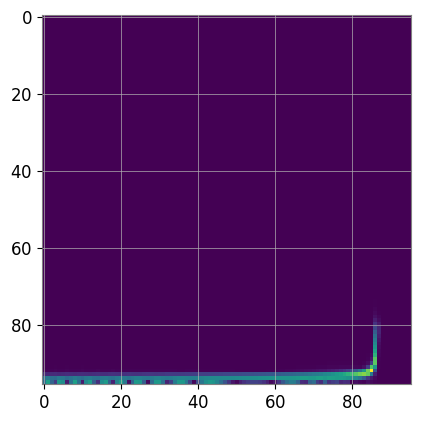

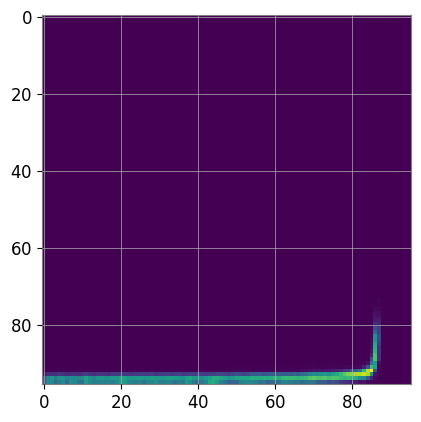

tf.Tensor(0.016962409, shape=(), dtype=float32)


In [ ]:
#@title Visualize Performance on Test Data { run: "auto" }
num = 14 #@param {type:"slider", min:0, max:39, step:1}
test_y = decoder.predict(test_x[num])
test_y = tf.squeeze(test_y, axis=0)
tx = tf.squeeze(tf.squeeze(test_x[num], axis=-1), axis=0)
plt.imshow(tx)
plt.show()
plt.imshow(test_y)
plt.show()
print(SSIMLoss(tx,test_y))

In [ ]:
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_4 (Separab  (None, 96, 96, 32)       73        
 leConv2D)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 separable_conv2d_5 (Separab  (None, 48, 48, 64)       2400      
 leConv2D)                                            

In [ ]:
back_end = tf.keras.models.Sequential()
for layer in decoder.layers[-9:]:
  back_end.add(layer)

In [ ]:
#Secondary Autoencoder (Residual AE)
import tensorflow.keras.layers as lay

input = tf.keras.Input(shape=(96,96,1))

#Primary AE processing
c0 = heavyAE(input)
c1 = lightAE(input)
c2 = very_lightAE(input)
start = tf.stack([tf.squeeze(c0, axis=-1),tf.squeeze(c1, axis=-1),tf.squeeze(c2, axis=-1)], axis=-1)

#Encoder
x = lay.SeparableConv2D(32, (3,3), padding="same")(start)
x = lay.BatchNormalization()(x)
x = lay.LeakyReLU(alpha=0.2)(x)
x = lay.MaxPool2D(2)(x)

x = lay.SeparableConv2D(64, (3,3), padding="same")(x)
x = lay.BatchNormalization()(x)
x = lay.LeakyReLU(alpha=0.2)(x)
x = lay.MaxPool2D(2)(x)

x = lay.Flatten()(x)
x = lay.Dense(16)(x)

#Decoder
output = back_end(x)

ae2 = tf.keras.Model(inputs=input, outputs=output)
ae2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 Heavy_AE (Functional)          (None, 96, 96, 1)    9527223     ['input_15[0][0]']               
                                                                                                  
 Light_AE (Functional)          (None, 96, 96, 1)    9527223     ['input_15[0][0]']               
                                                                                                  
 Very_Light_AE (Functional)     (None, 96, 96, 1)    9527223     ['input_15[0][0]']               
                                                                                           

In [ ]:
ae2 = tf.keras.models.load_model("drive/MyDrive/hwg_mark1/model", compile=False)
ae2._name = "Mark_1"
for layer in ae2.layers:
  layer.trainable = False
for layer in ae2.layers[-10:-1]:
  layer.trainable = True
ae2.summary()

for layer in decoder.layers:
  layer.trainable = True
for layer in decoder.layers[10:]:
  layer.trainable = False
decoder._name = "Final_Refiner"
decoder.summary()

Model: "Mark_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 Heavy_AE (Functional)          (None, 96, 96, 1)    9527223     ['input_15[0][0]']               
                                                                                                  
 Light_AE (Functional)          (None, 96, 96, 1)    9527223     ['input_15[0][0]']               
                                                                                                  
 Very_Light_AE (Functional)     (None, 96, 96, 1)    9527223     ['input_15[0][0]']               
                                                                                             

In [ ]:
input = tf.keras.Input(shape=(96,96,1))
x = ae2(input)
output = decoder(x)

ae3 = tf.keras.Model(inputs=input, outputs=output)
ae3._name = "Mark_2"
ae3.summary()

Model: "Mark_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 Mark_1 (Functional)         (None, 96, 96, 1)         29834581  
                                                                 
 Final_Refiner (Sequential)  (None, 96, 96, 1)         1252830   
                                                                 
Total params: 31,087,411
Trainable params: 1,184,937
Non-trainable params: 29,902,474
_________________________________________________________________


In [ ]:
#Update dataset as needed

# train_ds_full = tf.data.Dataset.from_tensor_slices((inputs[10:85]+gw170817+gw170817+gw170817, targets[10:85]+gw170817+gw170817+gw170817))
# train_ds_full = train_ds_full.map(x_y).batch(1).prefetch(25).shuffle(20)
train_ds_full = tf.data.Dataset.from_tensor_slices((gw170817+gw170817+gw170817+gw170817, gw170817+gw170817+gw170817+gw170817))
train_ds_full = train_ds_full.map(x_y).batch(1).prefetch(25).shuffle(20)
# train_ds_full = tf.data.Dataset.from_tensor_slices((inputs[40:85], targets[40:85]))
# train_ds_full = train_ds_full.map(x_y).batch(1).prefetch(25).shuffle(20)
# train_ds_full = tf.data.Dataset.from_tensor_slices((inputs[10:40]+gw170817+gw170817+gw170817, targets[10:40]+gw170817+gw170817+gw170817))
# train_ds_full = train_ds_full.map(x_y).batch(1).prefetch(25).shuffle(20)

In [ ]:
from tensorflow.keras.optimizers import Adam
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

very_lightAE.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy") #binary_crossentropy because of sigmoid output, default lr=0.001
very_lightAE.fit(train_ds_full, validation_data=val_ds_full, epochs=300)

Epoch 1/300
20/20 [==============================] - 14s 292ms/step - loss: 0.0351 - val_loss: 0.1042
Epoch 2/300
20/20 [==============================] - 3s 129ms/step - loss: 0.0350 - val_loss: 0.1025
Epoch 3/300
20/20 [==============================] - 3s 129ms/step - loss: 0.0349 - val_loss: 0.1015
Epoch 4/300
20/20 [==============================] - 3s 134ms/step - loss: 0.0348 - val_loss: 0.1009
Epoch 5/300
20/20 [==============================] - 4s 207ms/step - loss: 0.0347 - val_loss: 0.1002
Epoch 6/300
20/20 [==============================] - 6s 280ms/step - loss: 0.0347 - val_loss: 0.0997
Epoch 7/300
20/20 [==============================] - 3s 130ms/step - loss: 0.0347 - val_loss: 0.0993
Epoch 8/300
20/20 [==============================] - 6s 279ms/step - loss: 0.0346 - val_loss: 0.0990
Epoch 9/300
20/20 [==============================] - 3s 132ms/step - loss: 0.0346 - val_loss: 0.0989
Epoch 10/300
20/20 [==============================] - 3s 130ms/step - loss: 0.0346 - val_l

KeyboardInterrupt: ignored

###Rest of Secondary AE

In [ ]:
autoencoder = tf.keras.models.load_model("drive/MyDrive/hwg_mark2/model")

In [ ]:
light_ds_x = []
light_ds_y = []

for i in tqdm(range(5,35)):
  exact_path = "/content/drive/MyDrive/GW_Data/x/"+str(files[i])
  wav_x = tf.io.read_file(exact_path)
  audio, sr = tf.audio.decode_wav(wav_x)
  audio = tf.squeeze(audio, axis=-1)
  input, y = x_y(audio, audio)

  input = tf.expand_dims(input, axis=-1)
  input = tf.expand_dims(input, axis=0)
  x = autoencoder(input)
  x = tf.squeeze(x, axis=0)
  x = tf.py_function(func=clip, inp=[x, 92], Tout=tf.float32)

  light_ds_x.append(x)
  light_ds_y.append(y)

100%|██████████| 30/30 [00:05<00:00,  5.52it/s]


In [ ]:
light_ds = tf.data.Dataset.from_tensor_slices((light_ds_x, light_ds_y))
light_ds = light_ds.batch(1).prefetch(25).shuffle(20)

In [ ]:
heavy_ds_x = []
heavy_ds_y = []

for i in tqdm(range(40,240)):
  exact_path = "/content/drive/MyDrive/GW_Data/x/"+str(files[i])
  wav_x = tf.io.read_file(exact_path)
  audio, sr = tf.audio.decode_wav(wav_x)
  audio = tf.squeeze(audio, axis=-1)
  input, y = x_y(audio, audio)

  input = tf.expand_dims(input, axis=-1)
  input = tf.expand_dims(input, axis=0)
  x = autoencoder(input)
  x = tf.squeeze(x, axis=0)
  x = tf.py_function(func=clip, inp=[x, 92], Tout=tf.float32)

  heavy_ds_x.append(x)
  heavy_ds_y.append(y)

100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


In [ ]:
heavy_ds = tf.data.Dataset.from_tensor_slices((heavy_ds_x, heavy_ds_y))
heavy_ds = heavy_ds.batch(1).prefetch(25).shuffle(20)

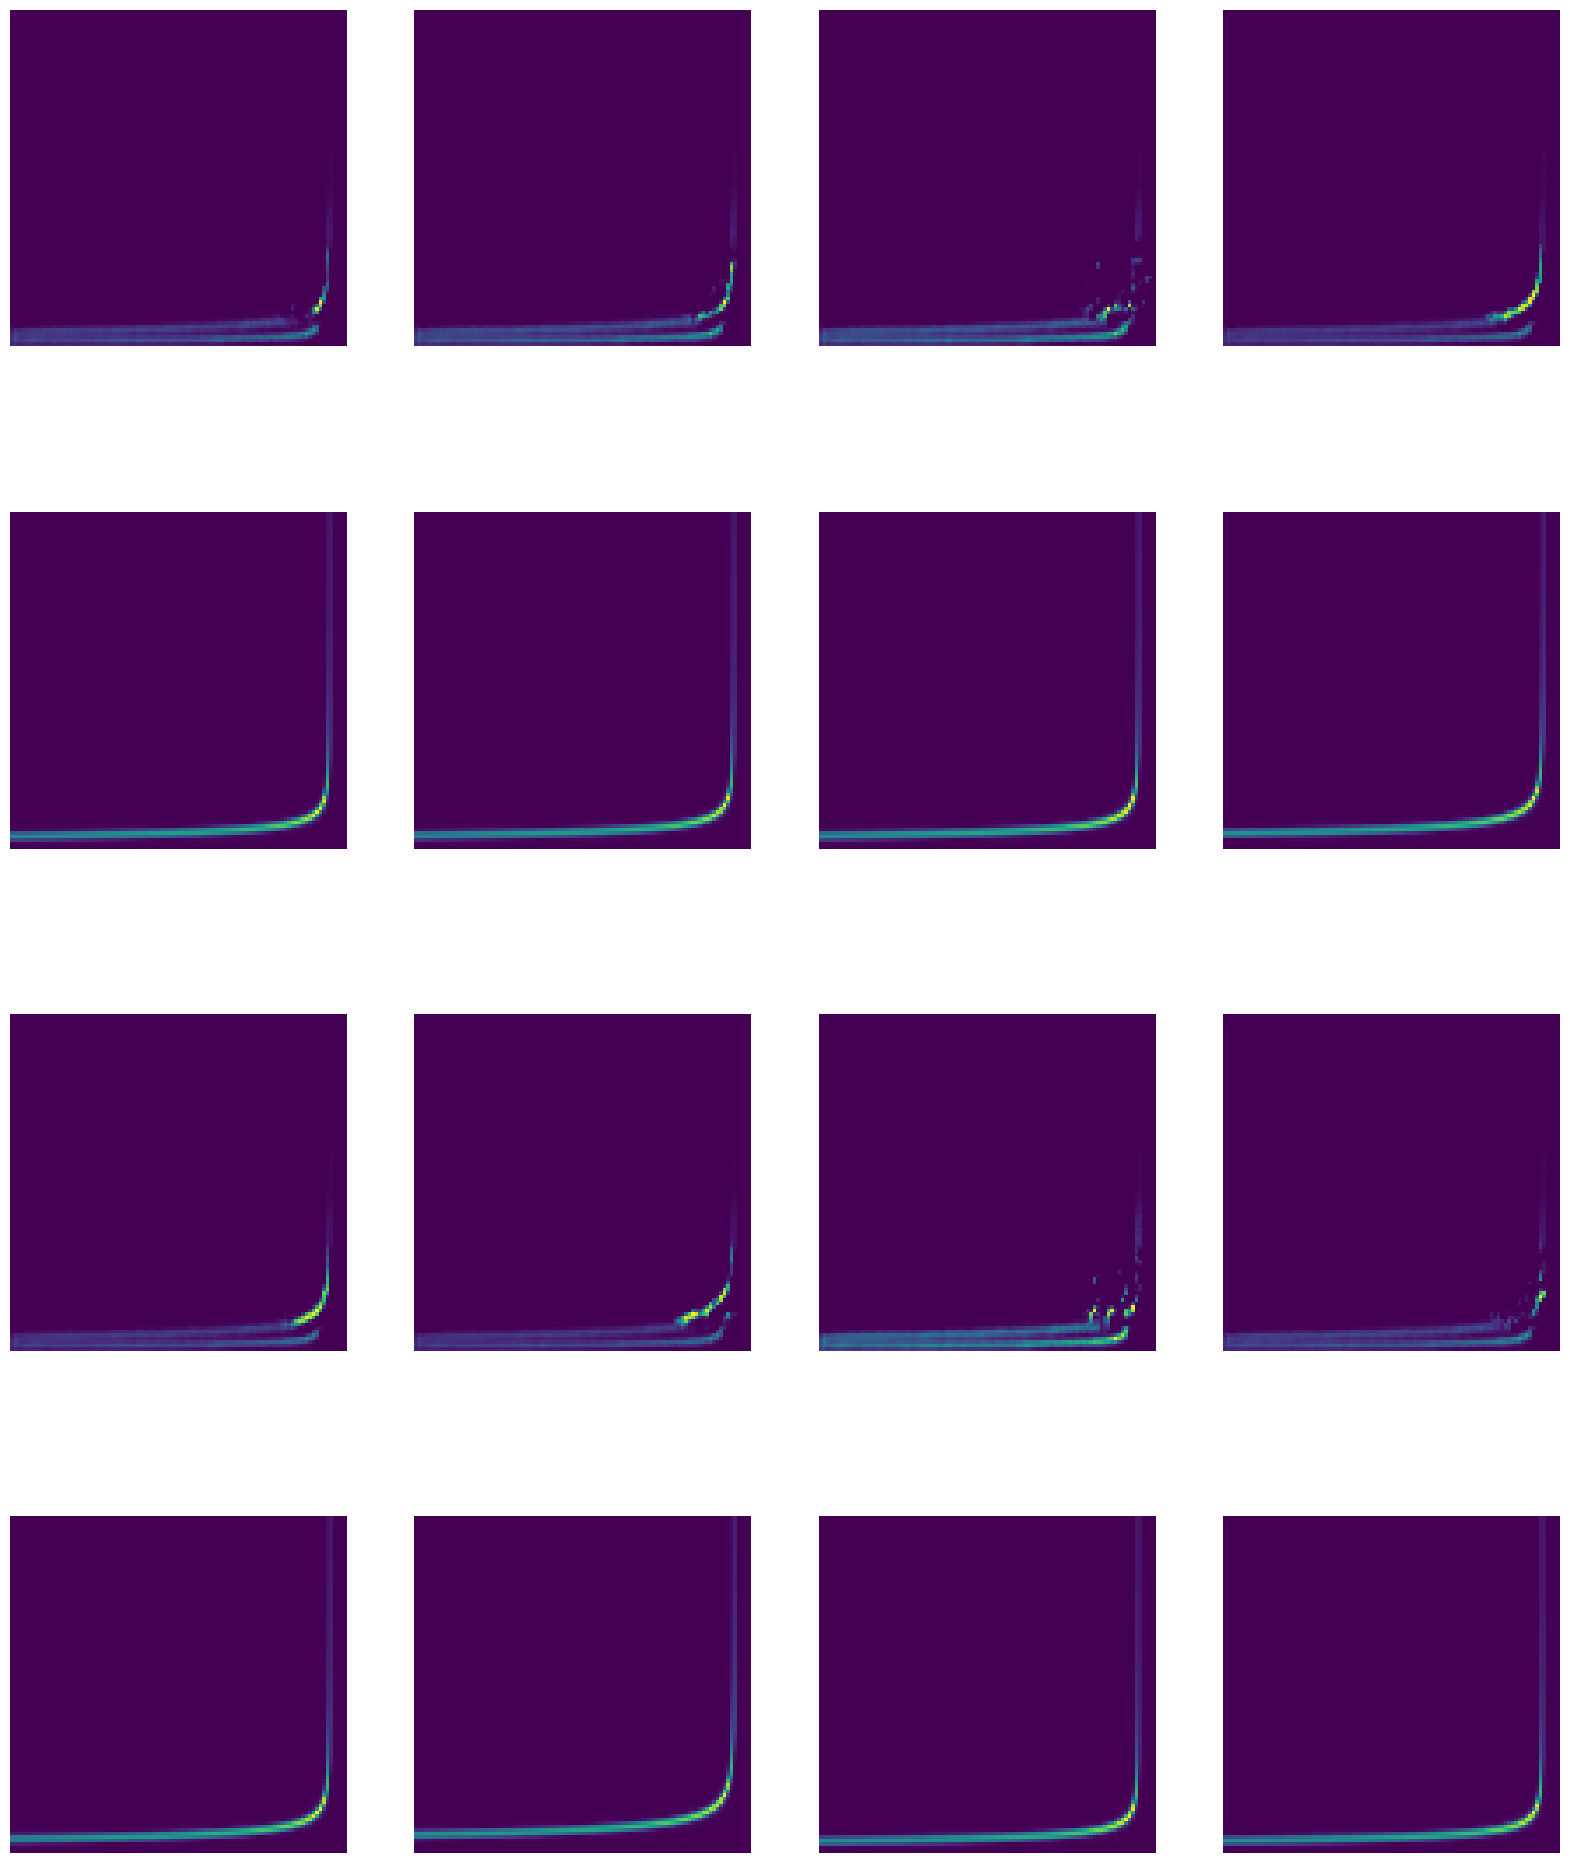

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20,25))

off = 0
for i in range(2):
  for a in range(4):
    axs[2*i,a].imshow((light_ds_x[4*i+a+off]))
    axs[2*i+1,a].imshow(light_ds_y[4*i+a+off])
    axs[2*i,a].axis('off')
    axs[2*i+1,a].axis('off')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam

lightAE.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy') #binary_crossentropy because of sigmoid output, default lr=0.001
lightAE.fit(light_ds, epochs=300)

Epoch 1/300
30/30 [==============================] - 7s 8ms/step - loss: 0.0352
Epoch 2/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 3/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 4/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 5/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 6/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 7/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 8/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 9/300
30/30 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 10/300
30/30 [==============================] - 0s 8ms/step - loss: 0.0352
Epoch 11/300
30/30 [==============================] - 0s 10ms/step - loss: 0.0352
Epoch 12/300
30/30 [==============================] - 0s 11ms/step - loss: 0.0352
Epoch 13/300
30/30 [===============

In [ ]:
lightAE.save("drive/MyDrive/hwg_secondaryAElight/model")

In [ ]:
heavyAE.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy') #binary_crossentropy because of sigmoid output, default lr=0.001
heavyAE.fit(heavy_ds, epochs=300)

In [ ]:
heavyAE.save("drive/MyDrive/hwg_secondaryAEheavy/model")

#AE Testing

In [ ]:
ae2 = tf.keras.models.load_model("drive/MyDrive/hwg_mark2/model")

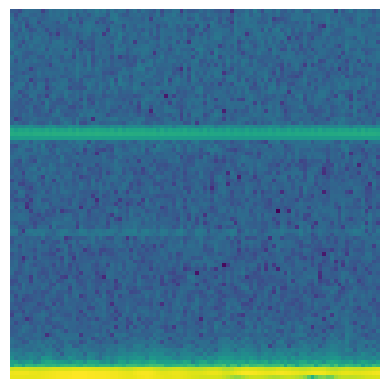

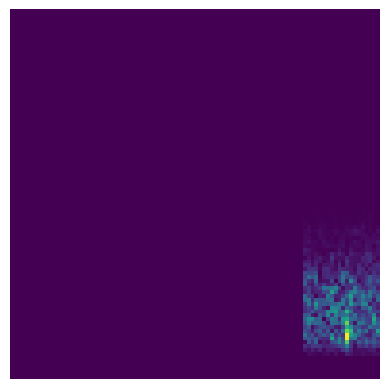

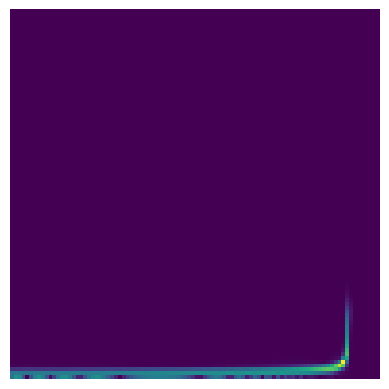

1/1 [==============================] - 0s 30ms/step


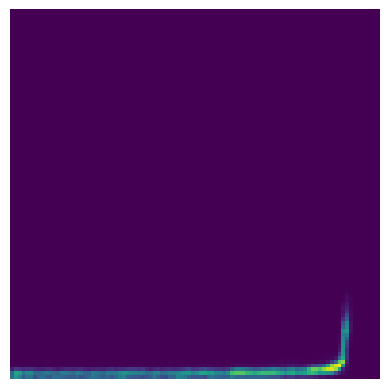

In [ ]:
#@title Visualize Performance on Test Data { run: "auto" }
num = 378 #@param {type:"slider", min:0, max:399, step:1}
exact_path = "/content/drive/MyDrive/GW_Data/x/"+str(files[num])
wav_x = tf.io.read_file(exact_path)
audio, sr = tf.audio.decode_wav(wav_x)
audio = tf.squeeze(audio, axis=-1)
x_test, y_test, gt, dirty = x_yForTest(audio, audio, 0.0004)

dirty_spect = spectros(tf.expand_dims(dirty, axis=-1))
dirty_spect = crop_upper(dirty_spect, 288)
dirty_spect = window(dirty_spect, 100)

plt.imshow(tf.math.log(dirty_spect))
plt.axis('off')
plt.show()
plt.imshow(x_test[:,:,0])
plt.axis('off')
plt.show()
plt.imshow(y_test)
plt.axis('off')
plt.show()

test_input = tf.expand_dims(x_test, axis=0)
cleaned_result1 = ae2.predict(test_input)
# cleaned_result2 = ae3.predict(test_input)
plot_this = tf.squeeze(tf.squeeze(cleaned_result1, axis=0), axis=-1)
plt.imshow(plot_this)
plt.axis('off')
plt.show()
# plot_this = tf.squeeze(tf.squeeze(cleaned_result2, axis=0), axis=-1)
# plt.imshow(plot_this)
# plt.show()
#print(SSIMLoss(test_input, cleaned_result1))

1/1 [==============================] - 0s 33ms/step


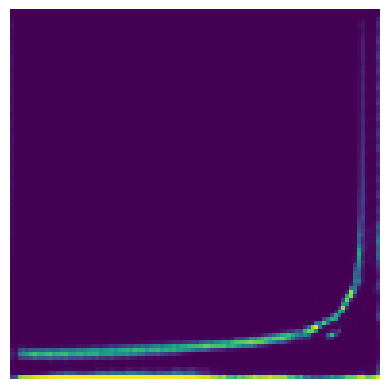

In [ ]:
initial = very_lightAE.predict(test_input)
plot_this = tf.squeeze(tf.squeeze(initial, axis=0), axis=-1)
plt.imshow(plot_this)
plt.axis('off')
plt.show()

In [ ]:
ae2.save("drive/MyDrive/hwg_mark2/model")

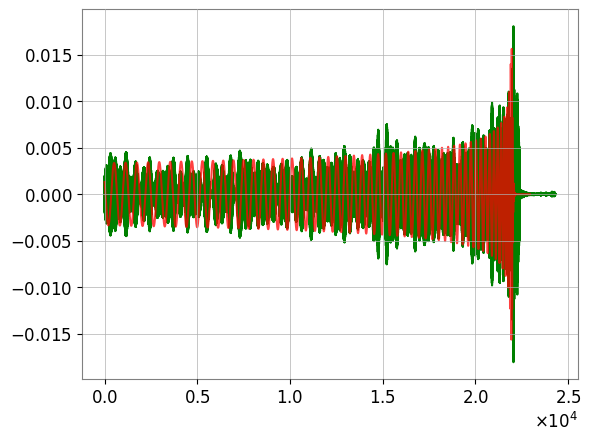

In [ ]:
import librosa
def scale(scalee, scaler, percentile=90):
  scale = np.percentile(scaler, percentile)/np.percentile(scalee, percentile)
  return scale*scalee

def to_wave(output):
  squeezed = tf.squeeze(output, axis=-1)

  filler = tf.zeros(((257-96), 96))

  inv_spec1 = tf.concat([filler, squeezed], axis=0)
  inv_spec1 = inv_spec1/np.amax(inv_spec1)
  
  y_inv = librosa.griffinlim(inv_spec1.numpy(), hop_length=256, win_length=512)
  return y_inv

inv_spec = tf.squeeze(cleaned_result1, axis=0)
y_inv = to_wave(inv_spec)
plt.plot(y_inv,'g')
plt.plot(scale(gt[int(-11.6*4096):-6*4096], y_inv), 'r', alpha=0.75)
plt.show()